In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

In [2]:
plt.style.use('ggplot')

In [3]:
with open('all_many_bubbles_output.json', 'r') as f:
    bubble_data = json.loads(f.read())

# The distributional consequences of bubbles.

In [4]:
runs = len(bubble_data)
runs

4

First, I reorganize the data.

In [5]:
bubble_types = []
bubble_prices = []
wealth_starts = []
wealth_ends = []
ginis_ot = []
palmas_ot = []
twtws_ot = []
risk_aversions = [] 
horizons = [] 
learning_abilities = [] 
chartist_expectations = [] 
fundamentalist_expectations = []

for r in range(runs):
    if bubble_data[r][1]:
        bubble_types += bubble_data[r][0]
        bubble_prices += bubble_data[r][1]
        wealth_starts += bubble_data[r][2]
        wealth_ends += bubble_data[r][3]
        ginis_ot += bubble_data[r][4]
        palmas_ot += bubble_data[r][5]
        twtws_ot += bubble_data[r][6]
        risk_aversions += bubble_data[r][7]
        horizons += bubble_data[r][8]
        learning_abilities += bubble_data[r][9]
        chartist_expectations += bubble_data[r][10]
        fundamentalist_expectations += bubble_data[r][11]

In [6]:
unique_bubble_types = list(set(bubble_types))
unique_bubble_types

[u'boom-bust', u'bust-boom']

## Inequality consequences

Calculate the differences in inequality ratio's for every bubble:

In [7]:
my_indices = [idx for idx, p in enumerate(bubble_prices) if p]

# clean bubble series 
bubble_types = [bubble_types[i] for i in my_indices]
bubble_prices = [bubble_prices[i] for i in my_indices]
wealth_starts = [wealth_starts[i] for i in my_indices]
wealth_ends = [wealth_ends[i] for i in my_indices]
ginis_ot = [ginis_ot[i] for i in my_indices]
palmas_ot = [palmas_ot[i] for i in my_indices]
twtws_ot = [twtws_ot[i] for i in my_indices]

ginis_ot_dif = [g[-1] - g[0] for g in ginis_ot]
palmas_ot_dif = [g[-1] - g[0] for g in palmas_ot]
twtws_ot_dif = [g[-1] - g[0] for g in twtws_ot]

For every bubble, calculate the lenght and magnitude of the bubble. 

In [8]:
bubble_lenght = [len(b) for b in bubble_prices]

# if boom or bust, magnitude is price difference 
bubble_magnitude = []
for idx, b_type in enumerate(bubble_types):
    if b_type in ['boom', 'bust']:
        bubble_magnitude.append(abs(bubble_prices[idx][-1] - bubble_prices[idx][0]))
    elif b_type in ['boom-bust', 'bust-boom']:
        bubble_magnitude.append(abs(np.mean(bubble_prices[idx]) - bubble_prices[idx][0]))
    else:
        #print(b_type)
        bubble_magnitude.append(pd.Series(bubble_prices[idx]).std())

Create a dataframe with all of this data. 

In [9]:
bubble_df = pd.DataFrame({'bubble_type': bubble_types, 'magnitude': bubble_magnitude, 'lenght': bubble_lenght, 
              'gini_diff': ginis_ot_dif, 'palma_diff': palmas_ot_dif, 'twtw_diff': twtws_ot_dif})
bubble_df['const'] = 1

In [10]:
bubble_df.head()

,bubble_type,gini_diff,lenght,magnitude,palma_diff,twtw_diff,const
0,boom-bust,0.000600,8,2.845628,0.002219,0.016746,1
1,boom-bust,0.000142,8,1.003513,0.000583,0.006581,1
2,boom-bust,-0.000032,19,5.078690,-0.000295,0.001137,1
3,boom-bust,0.000146,19,4.106649,0.000981,0.000847,1
4,boom-bust,0.000576,10,3.753272,0.004028,0.008209,1


Differentiate between different types of bubbles in the dataframe. 

In [11]:
boom_busts = bubble_df.query('bubble_type == "boom-bust"')
bust_booms = bubble_df.query('bubble_type == "bust-boom"')
busts = bubble_df.query('bubble_type == "bust"')
booms = bubble_df.query('bubble_type == "boom"')
no_bubble = bubble_df.query('bubble_type == "None"')

## Scatter plot analysis of bubble types and inequality

Text(0,0.5,'20-20 diff')

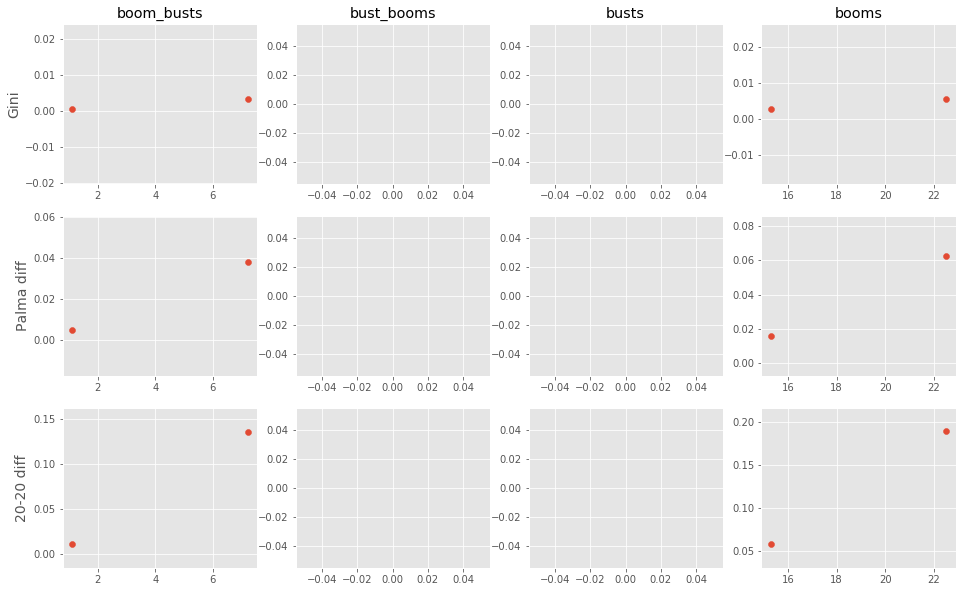

In [17]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12)) = plt.subplots(3, 4, figsize=[16,10])

ax1.scatter(boom_busts['magnitude'], boom_busts['gini_diff'])
ax2.scatter(bust_booms['magnitude'], bust_booms['gini_diff'])
ax3.scatter(busts['magnitude'], busts['gini_diff'])
ax4.scatter(booms['magnitude'], booms['gini_diff'])
#axn1.scatter(no_bubble['magnitude'], no_bubble['gini_diff'])

ax5.scatter(boom_busts['magnitude'], boom_busts['palma_diff'])
ax6.scatter(bust_booms['magnitude'], bust_booms['palma_diff'])
ax7.scatter(busts['magnitude'], busts['palma_diff'])
ax8.scatter(booms['magnitude'], booms['palma_diff'])
#axn2.scatter(no_bubble['magnitude'], no_bubble['palma_diff'])

ax9.scatter(boom_busts['magnitude'], boom_busts['twtw_diff'])
ax10.scatter(bust_booms['magnitude'], bust_booms['twtw_diff'])
ax11.scatter(busts['magnitude'], busts['twtw_diff'])
ax12.scatter(booms['magnitude'], booms['twtw_diff'])
#axn3.scatter(no_bubble['magnitude'], no_bubble['twtw_diff'])

ax1.set_title('boom_busts')
ax2.set_title('bust_booms')
ax3.set_title('busts')
ax4.set_title('booms')
#axn1.set_title('no_bubble')

ax1.set_ylabel('Gini', fontsize=14)
ax5.set_ylabel('Palma diff', fontsize=14)
ax9.set_ylabel('20-20 diff', fontsize=14)

## Regression analysis

### Gini

In [14]:
gini_res1 = sm.OLS(endog=boom_busts['gini_diff'], exog=boom_busts[['const', 'lenght', 'magnitude']], missing='drop').fit()
gini_res2 = sm.OLS(endog=bust_booms['gini_diff'], exog=bust_booms[['const', 'lenght', 'magnitude']], missing='drop').fit()
gini_res3 = sm.OLS(endog=busts['gini_diff'], exog=busts[['const', 'lenght', 'magnitude']], missing='drop').fit()
gini_res4 = sm.OLS(endog=booms['gini_diff'], exog=booms[['const', 'lenght', 'magnitude']], missing='drop').fit()

In [15]:
info_dict={'R-squared' : lambda x: "{}".format(x.rsquared), 
           'No. observations' : lambda x: "{}".format(int(x.nobs))}

results_table = summary_col(results=[gini_res1,gini_res2,gini_res3, gini_res4],
                            float_format='%0.4f',
                            stars = True,
                            model_names=['boom-bust',
                                         'bust-boom',
                                         'busts', 'booms'],
                            info_dict=info_dict,
                            regressor_order=['const', 'lenght', 'magnitude'])

results_table.add_title('Table 2 - OLS Regressions')

print(results_table)

NameError: name 'gini_res3' is not defined

### Palma

In [16]:
palma_reg1 = sm.OLS(endog=boom_busts['palma_diff'], exog=boom_busts[['const', 'lenght', 'magnitude']], missing='drop').fit()
palma_reg2 = sm.OLS(endog=bust_booms['palma_diff'], exog=bust_booms[['const', 'lenght', 'magnitude']], missing='drop').fit()
palma_reg3 = sm.OLS(endog=busts['palma_diff'], exog=busts[['const', 'lenght', 'magnitude']], missing='drop').fit()
palma_reg4 = sm.OLS(endog=booms['palma_diff'], exog=booms[['const', 'lenght', 'magnitude']], missing='drop').fit()

ValueError: zero-size array to reduction operation maximum which has no identity

In [17]:
info_dict={'R-squared' : lambda x: "{}".format(x.rsquared), 
           'No. observations' : lambda x: "{}".format(int(x.nobs))}

results_table = summary_col(results=[palma_reg1,palma_reg2,palma_reg3, palma_reg4],
                            float_format='%0.4f',
                            stars = True,
                            model_names=['boom-bust',
                                         'bust-boom',
                                         'busts', 'booms'],
                            info_dict=info_dict,
                            regressor_order=['const', 'lenght', 'magnitude'])

results_table.add_title('Table 2 - OLS Regressions')

print(results_table)

NameError: name 'palma_reg3' is not defined

## 20-20 Ratio

In [18]:
twtw_reg1 = sm.OLS(endog=boom_busts['twtw_diff'], exog=boom_busts[['const', 'lenght', 'magnitude']], missing='drop').fit()
twtw_reg2 = sm.OLS(endog=bust_booms['twtw_diff'], exog=bust_booms[['const', 'lenght', 'magnitude']], missing='drop').fit()
twtw_reg3 = sm.OLS(endog=busts['twtw_diff'], exog=busts[['const', 'lenght', 'magnitude']], missing='drop').fit()
twtw_reg4 = sm.OLS(endog=booms['twtw_diff'], exog=booms[['const', 'lenght', 'magnitude']], missing='drop').fit()

ValueError: zero-size array to reduction operation maximum which has no identity

In [19]:
info_dict={'R-squared' : lambda x: "{}".format(x.rsquared), 
           'No. observations' : lambda x: "{}".format(int(x.nobs))}

results_table = summary_col(results=[twtw_reg1,twtw_reg2,twtw_reg3, twtw_reg4],
                            float_format='%0.4f',
                            stars = True,
                            model_names=['boom-bust',
                                         'bust-boom',
                                         'busts', 'booms'],
                            info_dict=info_dict,
                            regressor_order=['const', 'lenght', 'magnitude'])

results_table.add_title('Table 2 - OLS Regressions')

print(results_table)

NameError: name 'twtw_reg3' is not defined

# Redistributional effects of asset bubbles

Calculate profits for all agents as the differences in wealth

In [18]:
profits = []
for idx, bubble in enumerate(bubble_types): 
    profits.append((np.array(wealth_ends[idx]) - np.array(wealth_starts[idx])) / np.array(wealth_starts[idx]))

Profits contains profits of all agents for every bubble episode. What I need is every individual profit with the bubble type next to it

In [19]:
all_profits = []
all_bubbles = []
chart_exp = []
fund_exp = []
learn_ab = []
hors = []
rav = []
for idx, p in enumerate(profits):
    all_profits += list(p)
    all_bubbles += [bubble_types[idx] for l in p]
    learn_ab += learning_abilities[idx]
    hors += horizons[idx]
    rav += risk_aversions[idx]
    chart_exp += [np.mean(c_exp) for c_exp in chartist_expectations[idx]]
    fund_exp += [np.mean(f_exp) for f_exp in fundamentalist_expectations[idx]]

Create dataframe of wealth changes and characteristics

In [20]:
redistr_df = pd.DataFrame({'wealth_change': all_profits, 'bubble_type': all_bubbles, 'risk_av': rav, 
              'horizon': hors, 'learning': learn_ab, 'chart_exp': chart_exp, 'fund_exp': fund_exp})
redistr_df['const'] = 1

In [21]:
redistr_df.head(3)

,bubble_type,chart_exp,fund_exp,horizon,learning,risk_av,wealth_change,const
0,boom,0.923952,0.036048,20,0.121684,1.901854,0.019833,1
1,boom,0.840159,0.039841,117,0.027372,2.417660,0.080333,1
2,boom,0.760108,0.159892,107,0.267493,2.725808,0.042436,1


Differentiate between the different types of bubbles:

In [22]:
boom_busts = redistr_df.query('bubble_type == "boom-bust"')
bust_booms = redistr_df.query('bubble_type == "bust-boom"')
busts = redistr_df.query('bubble_type == "bust"')
booms = redistr_df.query('bubble_type == "boom"')

### Scatter plot analysis

Text(0,0.5,'fund_exp')

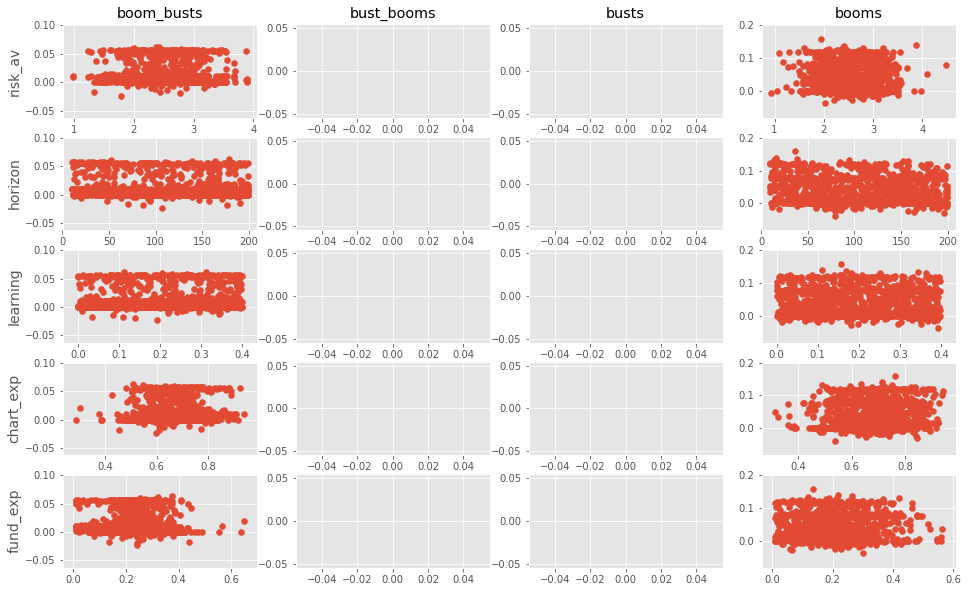

In [23]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12), 
      (ax13, ax14, ax15, ax16), (ax17, ax18, ax19, ax20)) = plt.subplots(5, 4, figsize=[16,10])

ax1.scatter(boom_busts['risk_av'], boom_busts['wealth_change'])
ax2.scatter(bust_booms['risk_av'], bust_booms['wealth_change'])
ax3.scatter(busts['risk_av'], busts['wealth_change'])
ax4.scatter(booms['risk_av'], booms['wealth_change'])
#axn1.scatter(no_bubble['magnitude'], no_bubble['gini_diff'])

ax5.scatter(boom_busts['horizon'], boom_busts['wealth_change'])
ax6.scatter(bust_booms['horizon'], bust_booms['wealth_change'])
ax7.scatter(busts['horizon'], busts['wealth_change'])
ax8.scatter(booms['horizon'], booms['wealth_change'])
#axn2.scatter(no_bubble['magnitude'], no_bubble['palma_diff'])

ax9.scatter(boom_busts['learning'], boom_busts['wealth_change'])
ax10.scatter(bust_booms['learning'], bust_booms['wealth_change'])
ax11.scatter(busts['learning'], busts['wealth_change'])
ax12.scatter(booms['learning'], booms['wealth_change'])
#axn3.scatter(no_bubble['magnitude'], no_bubble['twtw_diff'])

ax13.scatter(boom_busts['chart_exp'], boom_busts['wealth_change'])
ax14.scatter(bust_booms['chart_exp'], bust_booms['wealth_change'])
ax15.scatter(busts['chart_exp'], busts['wealth_change'])
ax16.scatter(booms['chart_exp'], booms['wealth_change'])
#axn2.scatter(no_bubble['magnitude'], no_bubble['palma_diff'])

ax17.scatter(boom_busts['fund_exp'], boom_busts['wealth_change'])
ax18.scatter(bust_booms['fund_exp'], bust_booms['wealth_change'])
ax19.scatter(busts['fund_exp'], busts['wealth_change'])
ax20.scatter(booms['fund_exp'], booms['wealth_change'])
#axn3.scatter(no_bubble['magnitude'], no_bubble['twtw_diff'])

ax1.set_title('boom_busts')
ax2.set_title('bust_booms')
ax3.set_title('busts')
ax4.set_title('booms')
#axn1.set_title('no_bubble')

ax1.set_ylabel('risk_av', fontsize=14)
ax5.set_ylabel('horizon', fontsize=14)
ax9.set_ylabel('learning', fontsize=14)
ax13.set_ylabel('chart_exp', fontsize=14)
ax17.set_ylabel('fund_exp', fontsize=14)

#TODO change layout

## Regression alalyses:

Regression model:

In [24]:
reg1 = sm.OLS(endog=boom_busts['wealth_change'], exog=boom_busts[['const', 'risk_av', 'horizon', 'learning', 'chart_exp', 'fund_exp']], missing='drop').fit()
reg2 = sm.OLS(endog=bust_booms['wealth_change'], exog=bust_booms[['const', 'risk_av', 'horizon', 'learning', 'chart_exp', 'fund_exp']], missing='drop').fit()
reg3 = sm.OLS(endog=busts['wealth_change'], exog=busts[['const', 'risk_av', 'horizon', 'learning', 'chart_exp', 'fund_exp']], missing='drop').fit()
reg4 = sm.OLS(endog=booms['wealth_change'], exog=booms[['const', 'risk_av', 'horizon', 'learning', 'chart_exp', 'fund_exp']], missing='drop').fit()

ValueError: zero-size array to reduction operation maximum which has no identity

In [25]:
info_dict={'R-squared' : lambda x: "{}".format(x.rsquared), 
           'No. observations' : lambda x: "{}".format(int(x.nobs))}

results_table = summary_col(results=[reg1, reg2, reg3, reg4],
                            float_format='%0.4f',
                            stars = True,
                            model_names=['boom-bust',
                                         'bust-boom',
                                         'busts', 'booms'],
                            info_dict=info_dict,
                            regressor_order=['const', 'risk_av', 'horizon', 'learning', 'chart_exp', 'fund_exp'])

results_table.add_title('Table - OLS Regressions')

print(results_table)

NameError: name 'reg2' is not defined